# Quantum-Classical Hybrid Computing: Workflows

These notebooks expand the content presented in the D-Wave webinar [Hybrid Quantum Programming](https://www.youtube.com/watch?v=EW44reo8Bn0), demonstrating how you can apply [Leap's](https://cloud.dwavesys.com/leap) cloud-based hybrid solvers and Ocean software's [*dwave-hybrid*](https://docs.ocean.dwavesys.com/en/stable/docs_hybrid/sdk_index.html) solvers to your problem, create hybrid workflows, and develop custom hybrid components.

This **second** notebook shows how you use *dwave-hybrid* components to create custom workflows for your problem:   

1. [A Sample Problem](#A-Sample-Problem) section reproduces the  [Quantum-Classical Hybrid Computing: Getting Started](01-hybrid-computing-getting-started.ipynb) example problem for use in this notebook.
2. [Basic Workflows](#Basic-Workflows) section demonstrates using basic *dwave-hybrid* components to build workflows.  
3. [Sample Workflows](#Sample-Workflows) section builds a few more-complex workflows.

Other content is provided in the following notebooks:

* [Quantum-Classical Hybrid Computing: Getting Started](01-hybrid-computing-getting-started.ipynb) notebook starts you off with Leap hybrid solvers and *dwave-hybrid* solvers and workflows.
* [Quantum-Classical Hybrid Computing: Components](03-hybrid-computing-components.ipynb) notebook shows how you can develop your own hybrid components for optimal performance. 

# A Sample Problem
This section recreates the [Quantum-Classical Hybrid Computing: Getting Started](01-hybrid-computing-getting-started.ipynb) problem for use in the following sections. 

<div class="alert alert-warning" role="alert" style="margin: 10px">Note: Problem size (nodes and density of edges) selected below ensures that runtimes on compute resources (virtual CPUs) provided by the Leap environment do not exceed a few minutes.</div>

<div class="alert alert-warning" role="alert" style="margin: 10px">Note: The code cell below imports from <code>helpers</code>, a folder colocated with this Jupyter Notebook. Users running it in <a href="https://cloud.dwavesys.com/leap">Leap</a> can see helper functions by selecting <i>Jupyter File Explorer View</i> on the <i>Online Learning</i> page.</div>

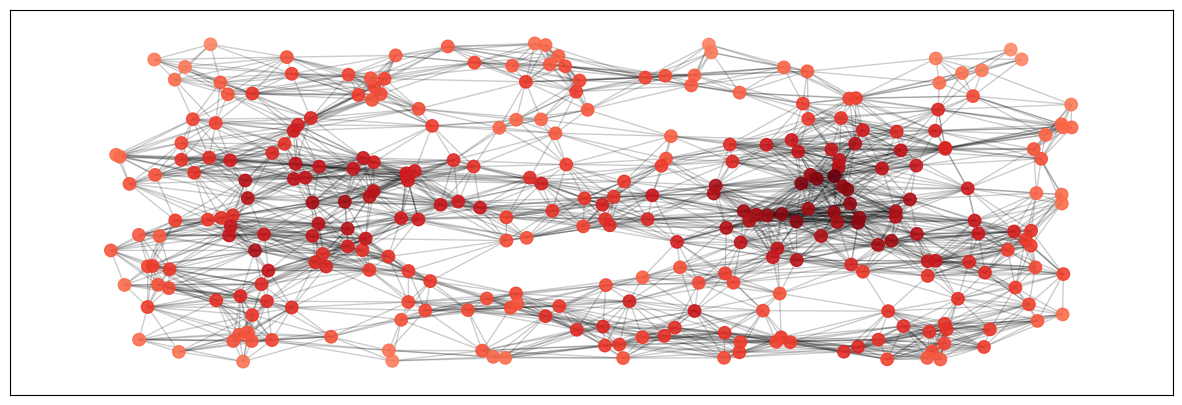

In [1]:
import matplotlib.pyplot as plt
from helpers.draw import plot 
%matplotlib inline
import networkx as nx
import dwave_networkx as dnx
import dimod

problem_node_count = 300

G = nx.random_geometric_graph(problem_node_count, radius=0.0005*problem_node_count)

qubo = dnx.algorithms.independent_set.maximum_weighted_independent_set_qubo(G)
bqm = dimod.BQM.from_qubo(qubo)

plot(G)

# Basic Workflows
A typical first step in developing a working hybrid application is to use a [*dwave-hybrid*](https://docs.ocean.dwavesys.com/en/stable/docs_hybrid/sdk_index.html) reference sampler or workflow. Your next step might be to customize the sampler or workflow for performance. 

For example, Kerberos runs classical samplers tabu and simulated annealing in parallel, with a D-Wave computer contributing to high-energy parts of the problem. Your application's problem may best fit one of these classical algorithms, or a different one entirely. *dwave-hybrid* enables you to quickly experiment with switching, adding, and removing workflow components.  

This notebook uses only existing *dwave-hybrid* components. The [Quantum-Classical Hybrid Computing: Components](03-hybrid-computing-components.ipynb) notebook shows how to modify components and create new components such as samplers. 

## States

The [Quantum-Classical Hybrid Computing: Getting Started](01-hybrid-computing-getting-started.ipynb) notebook demonstrated how workflows input [states](https://docs.ocean.dwavesys.com/en/stable/docs_hybrid/reference/core.html) representing a problem's binary quadratic model ([BQM](https://docs.ocean.dwavesys.com/en/stable/concepts/bqm.html)) and aim to produce, over one or more iterations, states updated with samples that are good solutions to the problem or parts of it. It mentioned that sometimes you may be in a position to provide initial samples with values better than random for your problem; for example, if you are intermittently running a very large problem, possibly on more than one solver, and saving intermediate results.

For the purpose of creating hybrid workflows, you should also understand that the *State* class is used to pass computation states between components and typical instantiations contain at least *samples* and *problem* fields. Some *dwave-hybrid* Runnables add fields such as *subproblem* and *subsamples* when decomposing large problems to run on the quantum computer. You can also add custom fields of your own. *dwave-hybrid* provides you with state-creation [methods](https://docs.ocean.dwavesys.com/en/stable/docs_hybrid/reference/core.html) and [utilities](https://docs.ocean.dwavesys.com/en/stable/docs_hybrid/reference/utilities.html).

The [Quantum-Classical Hybrid Computing: Components](03-hybrid-computing-components.ipynb) notebook describes the state-class and its methods in greater detail for the purpose of creating new hybrid components. 

Create an initial state using utility function `from_problem`, which, as used here, sets samples to the minimum value. 

In [2]:
import hybrid

initial_state = hybrid.State.from_problem(bqm)
print("Initial state has fields: {}.".format(initial_state.keys()))

Initial state has fields: dict_keys(['problem', 'samples']).


## Runnables
Workflows can start very simply and grow in complexity. A simple workflow might consist of just one [Runnable](https://docs.ocean.dwavesys.com/en/stable/docs_hybrid/reference/core.html), such as the first workflows below. 

These demonstrate two *dwave-hybrid* classes (primitives): 

* *State*-class components that hold a problem, samples, and optionally additional information.
* *Runnable*-class components that take input states, run for an iteration, and output updated states. 

For experimenting with and optimizing quantum-classical hybrid workflows using existing *dwave-hybrid* components, you typically need just two methods:

*  Runnable [run()](https://docs.ocean.dwavesys.com/en/stable/docs_hybrid/reference/core.html) method to execute an iteration of the workflow. It accepts a state in a [Future](https://docs.python.org/3/library/concurrent.futures.html#concurrent.futures.Future)-like object and returns a new state in a Future-like object. By default, it uses *hybrid.concurrency.thread_executor* to create an asynchronous call. 
* State [result()](https://docs.ocean.dwavesys.com/en/stable/docs_hybrid/reference/core.html) method to resolve the result using a *Future*-compatible resolution interface. 

The [Quantum-Classical Hybrid Computing: Components](03-hybrid-computing-components.ipynb) notebook provides more details on these and other methods, asynchronous and blocking calls between *dwave-hybrid* components, and additional information needed to modify and create your own components. 

The Runnable `Identity` below outputs a copy of its input state. Given input state, `initial_state`, the single-Runnable workflow below produces an output state, `output_state`, that is identical to the input state.

In [3]:
workflow = hybrid.Identity()

output_state = workflow.run(initial_state).result()
print(output_state == initial_state)

True


The Runnable `Dup` below duplicates `n=2` times the input state. In this workflow, output `output_states` is actually of type *States* class, a list of states. Such a Runnable can be used to build workflows with parallel processing. 

In [4]:
workflow = hybrid.Dup(2)

output_states = workflow.run(initial_state).result()
print("Output is a list containing {} states.".format(len(output_states)))

Output is a list containing 2 states.


Runnables may accept or require single or multiple states and output single or multiple states. *dwave-hybrid's* [state traits](https://docs.ocean.dwavesys.com/en/stable/docs_hybrid/reference/traits.html) check compatibility during workflow construction and runtime. You will see some examples in the following sections and use them in the [Quantum-Classical Hybrid Computing: Components](03-hybrid-computing-components.ipynb) notebook. 

Useful workflows typically process the input states in some way. The Runnable `Const` below, which sets values for state variables, is used for a simple manipulation of the input state. Such a Runnable enables you to manipulate an input state at any point in a workflow. An upcoming example makes a more-practical use of this capability.

In [5]:
print("Input state has samples: {}.".format(initial_state.samples.record.sample is not None))

output_state = hybrid.Const(samples=None).run(initial_state).result()
print("Output state has samples: {}.".format(output_state.samples is not None))

Input state has samples: True.
Output state has samples: False.


*dwave-hybrid* **samplers** are Runnables. A sampler's processing of input states usually aims to produce samples in its output state that are solutions to the problem, or part of it, given in its input state.   

In [6]:
workflow = hybrid.TabuProblemSampler()

state_updated = workflow.run(initial_state).result()

updated_state_energy = state_updated.samples.first.energy
initial_state_energy = initial_state.samples.first.energy
print("Updated state has energy {} versus initial state's {}.".format(updated_state_energy, 
                                                                      initial_state_energy))

Updated state has energy -36.0 versus initial state's 0.0.


<div class="alert alert-success" role="alert" style="margin: 10px"> 
    <b>Exercise:</b> By default, TabuProblemSampler runs for 100 ms. In the placeholder code cell below, modify the previous example to increase the timeout <a href="https://docs.ocean.dwavesys.com/en/stable/docs_hybrid/reference/samplers.html">parameter</a> or the tabu tenure and see if that produces a better solution. Open the hidden code cell below it for a solution. 
</div>

In [7]:
# Placeholder cell for exercise code

workflow = hybrid.TabuProblemSampler()

state_updated = workflow.run(initial_state).result()

updated_state_energy = state_updated.samples.first.energy
print("Updated state has energy {} versus initial state's {}.".format(updated_state_energy, 
                                                                      initial_state_energy))

Updated state has energy -37.0 versus initial state's 0.0.


In [8]:
# Click here to see solution:
workflow = hybrid.TabuProblemSampler(timeout=3000)

state_updated = workflow.run(initial_state).result()

updated_state_energy = state_updated.samples.first.energy
print("Updated state has energy {} versus initial state's {}.".format(updated_state_energy, 
                                                                      initial_state_energy))

Updated state has energy -37.0 versus initial state's 0.0.


<div class="alert alert-success" role="alert" style="margin: 10px"> 
    <b>Exercise:</b> Use the Runnable Lambda to add an "info" field to an input state. Open the hidden code cell below it for a solution.

<p>Hint 1: <a href="https://docs.ocean.dwavesys.com/en/stable/docs_hybrid/reference/flow.html">Lambda</a> creates a Runnable on the fly. You can use <code>Lambda(next)</code>&mdash;where callable <code>next</code> can be a lambda expression that accepts the Runnable instance and state instance&mdash;to process an input state. For example, <code>hybrid.Lambda(lambda _, s: s)</code>, like the <code>Identity</code> used above, returns a copy of the input state.</p><p>Hint 2: For this exercise, use the <a href="https://docs.ocean.dwavesys.com/en/stable/docs_hybrid/reference/core.html">State</a> method <code>updated()</code> that returns a copy of a state updated from specified arguments.</p>
</div>

In [ ]:
# Write and run your exercise code here:


In [9]:
# Click here to see solution:
add_info_runnable = hybrid.Lambda(lambda _, s: s.updated(info="Added an info field"))

state_updated = add_info_runnable.run(initial_state).result()
print(state_updated.info)

Added an info field


## Branches
The updated state of a Runnable can be pipelined into a second Runnable. Below, two tabu searches with different parameters are run in sequence. Such sequentially executed components constitute a *Branch*, a subclass of Runnable. 

In [10]:
workflow = hybrid.TabuProblemSampler(tenure=5) | hybrid.TabuProblemSampler(tenure=30)

state_updated = workflow.run(initial_state).result()
hybrid.print_counters(workflow)

* Branch
  (timers)
  - 'dispatch': cnt = 1, cumtime = 0.000 s, avgtime = 0.000 s
  - 'dispatch.init': cnt = 1, cumtime = 0.000 s, avgtime = 0.000 s
  - 'dispatch.next': cnt = 1, cumtime = 0.239 s, avgtime = 0.239 s
  - 'dispatch.resolve': cnt = 1, cumtime = 0.000 s, avgtime = 0.000 s

    * TabuProblemSampler
      (timers)
      - 'dispatch': cnt = 1, cumtime = 0.134 s, avgtime = 0.134 s
      - 'dispatch.init': cnt = 1, cumtime = 0.000 s, avgtime = 0.000 s
      - 'dispatch.next': cnt = 1, cumtime = 0.134 s, avgtime = 0.134 s
      - 'dispatch.resolve': cnt = 1, cumtime = 0.000 s, avgtime = 0.000 s

    * TabuProblemSampler
      (timers)
      - 'dispatch': cnt = 1, cumtime = 0.105 s, avgtime = 0.105 s
      - 'dispatch.init': cnt = 1, cumtime = 0.000 s, avgtime = 0.000 s
      - 'dispatch.next': cnt = 1, cumtime = 0.105 s, avgtime = 0.105 s
      - 'dispatch.resolve': cnt = 1, cumtime = 0.000 s, avgtime = 0.000 s



The previous subsection demonstrated using Runnable `Const` to configure an input state at some point in a workflow. Here it ensures that `TabuProblemSampler` generates its own initial set of random samples rather than start its search on the input state's samples, which were initialized to all zeros. An upcoming subsection makes further use of this capability. 

In [11]:
branch = (hybrid.Const(samples=None) | hybrid.TabuProblemSampler())

state_updated = branch.run(initial_state).result()
print("Updated state has energy {}.".format(state_updated.samples.first.energy))

Updated state has energy -35.0.


<div class="alert alert-success" role="alert" style="margin: 10px"> 
    <b>Exercise:</b> Use Runnable Const to set the sample values to all ones in the input state to TabuProblemSampler.
    Open the hidden code cell below it for a solution.
    
<p>Hint: You have seen that the samples field of a state is of type <a href="https://docs.ocean.dwavesys.com/en/stable/docs_dimod/reference/sampleset.html">dimod SampleSet</a>, which has methods to convert from samples, and state has its own convenience method, <code>from_sample</code>, for constructing a state from a raw (dict) sample.</p>     
</div>

<div class="alert alert-warning" role="alert" style="margin: 10px">Note: When using a hybrid tabu sampler, be sure to correctly configure how it expands input-state samples into its initial states.</div>

In [ ]:
# Write and run your exercise code here:


In [12]:
# Click here to see solution:
all_ones = {var: 1 for var in initial_state.samples.variables}
samples_initial = hybrid.State.from_sample(all_ones, bqm).samples

# Alternatively:
#samples_initial = dimod.SampleSet.from_samples({var: 1 for var in initial_state.samples.variables}, 
#                                               "BINARY", 0)

states_updated = (hybrid.Const(samples=samples_initial) 
                  | hybrid.TabuProblemSampler()
                 ).run(initial_state).result()
print("Updated state has energy {}.".format(state_updated.samples.first.energy))

Updated state has energy -35.0.


### A Practical Example 
A standard branch in hybrid workflows is the sequence of processing that enables a quantum computer to participate in solving problems of arbitrary size. Unless your problem is small enough to fit in its entirety on a quantum processing unit (QPU), you must decompose it into smaller parts. These can be submitted to a D-Wave computer and the returned samples merged into the larger problem's samples.  

Subsection [Decomposition](#Decomposition) below demonstrates that there are numerous ways to decompose a problem. Deferring detailed explanation to that subsection, the code here uses the `EnergyImpactDecomposer` decomposer to select a subproblem of `sub_size=40` variables maximally contributing to the problem energy and the `SplatComposer` composer to then overwrite current samples with subproblem samples. `QPUSubproblemAutoEmbeddingSampler` handles the submission of the subproblem to the quantum computer. 

In [13]:
sub_size = 40
branch_quantum = ( hybrid.EnergyImpactDecomposer(size=sub_size) |
                   hybrid.QPUSubproblemAutoEmbeddingSampler(num_reads=10) |
                   hybrid.SplatComposer() )

state_updated = branch_quantum.run(initial_state).result()

initial_state_energy = initial_state.samples.first.energy 
updated_state_energy = state_updated.samples.first.energy 
subproblem_variables = state_updated.subsamples.variables
print("Initial energy: {}. Energy of {} achieved by incorporating samples for subproblem variables {}.".format(
             initial_state_energy, updated_state_energy, subproblem_variables))

ValueError: API token not defined

### Parallel Branches: Blocking, SIMO
You can run several branches in parallel. The *Parallel* class (a Runnable subclass, of course) inputs a single state, executes all its branches until the **last** one terminates, and outputs a list of states. 

The workflow below runs the `branch_quantum` from the previous example in parallel to a tabu search. Each branch outputs a state and these accumulate in the output states of `Parallel`.  This workflow is an example that complies with the SIMO [state trait](https://docs.ocean.dwavesys.com/en/stable/docs_hybrid/reference/traits.html): single input, multiple output.

In [14]:
workflow = hybrid.Parallel(hybrid.TabuProblemSampler(),
                           branch_quantum)

states_updated = workflow.run(initial_state).result()
print("Output is a `States` object with {} states.".format(len(states_updated)))

NameError: name 'branch_quantum' is not defined

### Parallel Branches: Blocking, MIMO
The Runnable `Branches` is similar to `Parallel` but it inputs a state for each of its branches. In the example below, the `Branches` component complies with the MIMO [state trait](https://docs.ocean.dwavesys.com/en/stable/docs_hybrid/reference/traits.html): multiple inputs, multiple outputs. 

In [ ]:
workflow = hybrid.Dup(2) | hybrid.Branches(hybrid.TabuProblemSampler(),
                                           branch_quantum)

states_updated = workflow.run(initial_state).result()

num_problem_variables = len(states_updated[0].problem.variables)
num_subproblem_variables = len(states_updated[1].subproblem.variables)
print("Tabu ran on {} variables and the quantum branch on {} of those.".format(
       num_problem_variables, num_subproblem_variables))

<div class="alert alert-success" role="alert" style="margin: 10px"> 
    <b>Exercise:</b> Rewrite the previous workflow using Runnable <a href="https://docs.ocean.dwavesys.com/en/stable/docs_hybrid/reference/flow.html">Map</a> to run a TabuProblemSampler in both branches.
    Open the hidden code cell below it for a solution.
</div>

In [ ]:
# Write and run your exercise code here:


In [ ]:
# Click here to see solution:
workflow = hybrid.Dup(2) | hybrid.Map(hybrid.TabuProblemSampler())

states_updated = workflow.run(initial_state).result()

updated_energies = [states_updated[i].samples.first.energy for i in [0, 1]]
print("Updated states have energies {}.".format(updated_energies))

### Parallel Branches: Non-Blocking
The *Race* class executes all its branches until the **first** one terminates. It inputs a single state and outputs a *States*-class object, which might have partial results for some of the branches. 

Use it to run a short tabu search in parallel to a long simulated annealing. Branch execution depends on the execution environment's resources and their allocation. Typically, for this notebook's example problem, the output state for simulated annealing has fewer than the requested number of sample sets (if your results differ, modify the parameters, for example, increase `num_reads` for the simulated annealing). 

In [ ]:
workflow = hybrid.Race(hybrid.TabuProblemSampler(num_reads=2, timeout=10),
                       hybrid.SimulatedAnnealingProblemSampler(num_reads=1000))

states_updated = workflow.run(initial_state).result()
print("Number of sample sets in the two states are {} and {}.".format(
       len(states_updated[0].samples), len(states_updated[1].samples)))

## Selecting Samples
In many workflows that execute parallel sampling, the next stage selects the best states, according to some criterion. Runnable `ArgMin` inputs a *States* list of states and by default outputs the state with lowest energy. 

In [ ]:
workflow = (hybrid.Parallel(hybrid.TabuProblemSampler(num_reads=2, timeout=10),
            hybrid.SimulatedAnnealingProblemSampler(num_reads=1)) |
            hybrid.ArgMin() )

state_updated = workflow.run(initial_state).result()
print("Updated state has {} sample sets with lowest energy {}.".format(
       len(state_updated.samples), state_updated.samples.first.energy))

### Customizing Sample Selection
Your application might have additional considerations for selecting the best solutions. The next (pedagogical-only) example demonstrates selection that prioritizes quicker sampling over potentially better solutions. 

The first cell sets `known_best` to the best solution found running the default tabu search `num_read=10` times. 

The second cell defines three samplers with longer runtimes that use `Const` to tag their output state with those runtimes. Function `penalty` calculates a penalty proportional to runtime. Function `prefer_fast` returns the best energy of each output state penalized by runtime, and is substituted in `ArgMin` for the default key callable, which selects the state with best energy.

In [ ]:
result = hybrid.TabuProblemSampler(num_reads=10).run(initial_state).result()
known_best = result.samples.first.energy

print("Best energy found with default tabu run time is {}.".format(known_best))

In [ ]:
sampler_200 = hybrid.Const(info=200) | hybrid.TabuProblemSampler(num_reads=3, timeout=200)
sampler_400 = hybrid.Const(info=400) | hybrid.TabuProblemSampler(num_reads=3, timeout=400)
sampler_600 = hybrid.Const(info=600) | hybrid.TabuProblemSampler(num_reads=3, timeout=600)

def penalty(timeout):
    return -0.01 * known_best * timeout/100

def prefer_fast(si):
    weighted_energy = si.samples.first.energy + penalty(si.info)
    print ("Sampler_{} energy {} is penalized {} for time-weighted energy: {}.".
           format(si.info, si.samples.first.energy, penalty(si.info), weighted_energy))
    return weighted_energy

Run three tabu searches and select the output state with lowest energy weighted by runtime: 

In [15]:
workflow = (hybrid.Parallel(sampler_200, sampler_400, sampler_600)|
            hybrid.ArgMin(key=prefer_fast))

state_updated = workflow.run(initial_state).result()
print("ArgMin using prefer_fast selected a state with energy {}.".format(state_updated.samples.first.energy))

NameError: name 'sampler_200' is not defined

<div class="alert alert-success" role="alert" style="margin: 10px"> 
    <b>Bonus Exercise:</b> Run a few parallel tabu searches and have <code>ArgMin</code> prioritize the nodes with indices in the bottom third of example graph G. Test your code in the EXERCISE TEST CELL below. Open the hidden code cell above it for a solution.
<p>Consider an example where G represents a sprinkler system and the lowest-numbered sprinklers water more important crops than the higher-numbered sprinklers. The recommended approach for solving such a problem graph is to weight the nodes by importance as part of the QUBO formulation but just for fun, try writing an `ArgMin` key that, given a choice of solutions with energies that are no higher than 5% of the previously found best solution, prefers a solution with more sprinklers for the important crops.</p></div>

In [ ]:
# Write your exercise code here:
known_best = hybrid.TabuProblemSampler(num_reads=10).run(initial_state).result().samples.first

def penalty(sample):
    pass

def prefer_first_third(si):
    """Prefer solutions within 5% of best with maximum bottom-third nodes."""
    pass

In [ ]:
# Click here to see solution:
known_best = hybrid.TabuProblemSampler(num_reads=10).run(initial_state).result().samples.first
print("Best energy found is {}.".format(known_best.energy)) 

def penalty(sample):
    """Set penalty equal to the number of selected bottom-third nodes."""
    return -len([val for key, val in sample.items() if key<0.3*problem_node_count and val>0])

def prefer_first_third(si):
    """Prefer solutions within 5% of best with maximum bottom-third nodes."""
    if si.samples.first.energy > 0.95*known_best.energy:
        return si.samples.first.energy
    else:     
        weighted_energy = si.samples.first.energy + penalty(si.samples.first.sample)
        print ("Sample energy {} is penalized {} for node-weighted energy: {}.".format
                      (si.samples.first.energy, penalty(si.samples.first.sample), weighted_energy))
        return weighted_energy  

In [ ]:
# EXERCISE TEST CELL
workflow = (hybrid.Dup(4) | hybrid.Map(hybrid.TabuProblemSampler()) |
            hybrid.ArgMin(key=prefer_first_third) )

state_updated = workflow.run(initial_state).result()
print("Updated state has {} first-third nodes selected and energy {}.".format(len([val for key, val in state_updated.samples.first.sample.items() if key<0.3*problem_node_count]), state_updated.samples.first.energy))

## Iterating
There are various reasons for iterating over the sampling process; for example, a sampler might not have appropriate logic to terminate to your preferred criterion, your application might take advantage of seeding one sampler with the output of another, and so on. 

The *LoopUntilNoImprovement* class (alias *Loop*, another Runnable subclass) iterates its components until an explicitly defined or default termination, feeding back the output state of one iteration as the input state to the next. The simple example below terminates after a maximum of `max_iter` executions of Runnable `TabuProblemSampler`.  

In [ ]:
workflow = hybrid.Loop(hybrid.TabuProblemSampler(num_reads=2, timeout=5), max_iter=3) 

state_updated = workflow.run(initial_state).result()
hybrid.print_counters(workflow)

The [Branches](#Branches) subsection mentioned that you can prevent `TabuProblemSampler` from starting each iteration from the samples of the previous iteration by using `Const` to set `samples=None` in the state. An exercise in subsection [Runnables](#Runnables) used `Lambda` to add an *info* field to an input state. 

The next example compares two tabu searches iterated in Runnable `Loop`: one is initialized with the previous iteration's samples; another uses `Const` to start each iteration from a random sample. `Lambda` is used to track, in a *tracked_energy* field, the energy found in each iteration.

In [ ]:
runtime = 20
iterations = 50

energy_tracker = hybrid.Lambda(lambda _, s: s.updated(
                     tracked_energy=s.tracked_energy + [s.samples.first.energy]))

sampler_init_previous = hybrid.TabuProblemSampler(timeout=runtime) | energy_tracker
sampler_init_random = ( hybrid.Const(samples=None) | 
                       hybrid.TabuProblemSampler(timeout=runtime) | 
                       energy_tracker )

workflow_init_previous = hybrid.Loop(sampler_init_previous, max_iter=iterations)
workflow_init_random = hybrid.Loop(sampler_init_random, max_iter=iterations)

energy_init_previous = workflow_init_previous.run(initial_state.updated(
                           tracked_energy=[])).result().tracked_energy
energy_init_random = workflow_init_random.run(initial_state.updated(
                           tracked_energy=[])).result().tracked_energy

plt.figure(figsize=(10,5))
plt.plot(range(iterations), energy_init_previous, 'r.-', label='Initialized to previous iteration') 
plt.plot(range(iterations), energy_init_random, 'b.-', label='Initialized to random')
plt.legend()

Try increasing the tabu search runtime to see if performance of the randomly initialized sampler improves:

* runtime = 200
* runtime = 2000

Note: For tabu searches of 2 seconds, keeping 50 iterations will result in **several minutes' runtime**. You might want to decrease the number of iterations from the current `iterations = 50`.  

<div class="alert alert-success" role="alert" style="margin: 10px"> 
    <b>Exercise:</b> Instead of using <code>Const</code> to force the tabu search to start from a random sample, use it to initialize the search from a good solution and compare that to the search initialized from the previous output state. Open the hidden code cell below it for a solution.
</div>

In [ ]:
# Write and run your exercise code here:


In [ ]:
# Click here to see solution:
runtime = 20
iterations = 50

energy_tracker = hybrid.Lambda(lambda _, s: s.updated(
                     tracked_energy=s.tracked_energy + [s.samples.first.energy]))

good = hybrid.TabuProblemSampler(num_reads=10, timeout=100).run(initial_state).result()
samples_initial = hybrid.State.from_sample(good.samples.first.sample, good.problem).samples

sampler_init_previous = hybrid.TabuProblemSampler(timeout=runtime) | energy_tracker
sampler_init_good = ( hybrid.Const(samples=samples_initial) | 
                     hybrid.TabuProblemSampler(timeout=runtime) | 
                     energy_tracker )

workflow_init_previous = hybrid.Loop(sampler_init_previous, max_iter=iterations)
workflow_init_good = hybrid.Loop(sampler_init_good, max_iter=iterations)

energy_init_previous = workflow_init_previous.run(initial_state.updated(
                           tracked_energy=[])).result().tracked_energy
energy_init_good = workflow_init_good.run(initial_state.updated(
                           tracked_energy=[])).result().tracked_energy

plt.figure(figsize=(10,5))
plt.plot(range(iterations), energy_init_previous, 'r.-', label='Initialized to previous iteration') 
plt.plot(range(iterations), energy_init_good, 'b.-', label='Initialized to a good solution')
plt.legend()

## Revisiting Kerberos

The [Quantum-Classical Hybrid Computing: Getting Started](01-hybrid-computing-getting-started.ipynb) notebook introduced you to Kerberos, an out-of-the-box hybrid sampler. 

<img src="images/kerberos.png" width=500x>

That notebook described it as looping over three sampling branches in parallel, selecting after each iteration the best results from tabu search, simulated annealing, and QPU sampling of a subproblem. Now you understand how this workflow is structured:

* Classical samplers *Interruptable Tabu Sampler* and *Interruptable SA Sampler*  
  run (on CPU) until interrupted by the QPU branch. 
* *Energy Impact Decomposer* selects a subset of the problem's variables (those
  that maximally contribute to the problem energy); *QPU Sampler* submits 
  subproblems to the quantum computer; and *SplatComposer* inserts 
  subproblems' samples into problem samples.
* *ArgMin* selects the best samples from an iteration, which terminates when 
  the quantum computer returns samples. 
* *Loop* iterates these *Racing Branches* until a termination condition is reached.  

The next section provides details on the decomposition that is at the heart of adding the quantum computer into the workflow. The [Quantum-Classical Hybrid Computing: Components](03-hybrid-computing-components.ipynb) notebook provides a deeper understanding of the components. 

# Sample Workflows
This section demonstrates a few example workflows.

## Decomposition
Decomposition is crucial for efficient quantum-classical hybrid workflows: for the quantum computer to contribute, workflows must allocate to it the appropriate parts of the problem. Intelligent decomposition is in itself a challenging problem. 

*dwave-hybrid* provides an `EnergyImpactDecomposer` component that selects a subproblem of variables maximally contributing to the problem energy. It provides a number of configuration options and in conjunction with additional components can execute a variety of decompositions.   

Given an initial state, `EnergyImpactDecomposer` returns a state updated with a `subproblem` field containing selected variables:

In [ ]:
sub_size = 40

state_updated = hybrid.EnergyImpactDecomposer(size=sub_size).run(initial_state).result()

plot(G, subgraphs=[G.subgraph(state_updated.subproblem.variables)])

For the problem created in the [A Sample Problem](#A-Sample-Problem) section, in which all variables contribute equally, decomposing by maximum energy contribution tends to select an indexical sequence of variables. You can specify different traversal methods through the problem variables with the `traversal` [parameter](https://docs.ocean.dwavesys.com/en/stable/docs_hybrid/reference/decomposers.html); for example, breadth-first traversal ("bfs") or priority-first traversal ("pfs").  

In [ ]:
state_updated = hybrid.EnergyImpactDecomposer(size=sub_size, traversal="bfs").run(initial_state).result()

plot(G, subgraphs=[G.subgraph(state_updated.subproblem.variables)])

The `rolling` parameter configures the component so that successive calls for the same problem produce subproblems on different variables, selected by rolling down the list of all variables sorted by decreasing impact, until a fraction of the problem size set by the `rolling_history` parameter.  

The next cell loops `max_iter` times on the `EnergyImpactDecomposer`. To see which variables are selected, a `Lambda` is added that accumulates  the `sub_size` selected variables to a custom informational field, `rolled_variables`, in the updated state. 

Try experimenting with the `traversal` and `size` parameters.

In [ ]:
sub_size = 15
subgraphs = 3

iteration = (hybrid.EnergyImpactDecomposer(size=sub_size, rolling_history=0.85, traversal="bfs") | 
             hybrid.Lambda(lambda _, s: s.updated(
                               rolled_variables=s.rolled_variables+[list(s.subproblem.variables)])))

workflow = hybrid.LoopUntilNoImprovement(iteration, max_iter=3) 

state_updated = workflow.run(initial_state.updated(rolled_variables=[])).result()

plot(G, subgraphs=[G.subgraph(state_updated.rolled_variables[i]) for i in range(len(state_updated.rolled_variables))], 
                  max_subs=subgraphs, subtitles=True)

Runnable `Unwind` iterates over a given Runnable until it raises an `EndOfStream`. Given the `EnergyImpactDecomposer`, it decomposes the problem into the number of subproblems of the specified size, `sub_size`, that can fit into the specified `rolling_history` fraction of the problem size.     

In [ ]:
sub_size = 20

workflow = hybrid.Unwind(hybrid.EnergyImpactDecomposer(size=sub_size, rolling_history=0.85))
states_updated = workflow.run(initial_state).result()

print("Iterated over {} subproblems: \n".format(len(states_updated)))
for i in range(len(states_updated)):
    print(set(states_updated[i].subproblem.variables))

## Postprocessing 
The quantum computer's strength is in quickly finding diverse good solutions to hard problems. Its strength is not in precision numerical calculations, so often the best solution it provides is close but not quite the best in the vicinity. At that point, it is often useful to run a quick classical search to refine the solutions. 

This example creates a random binary quadratic model that fits the working graph of a QPU. Such problems can have very large numbers of local minima, making the QPU less likely to return the exact solution, especially when, as here, a low number of reads, `num_reads`, is requested.

In [ ]:
from dwave.system import DWaveSampler
sampler_qpu = DWaveSampler()

bqm_ran5 = dimod.generators.random.ran_r(r=5, graph=(sampler_qpu.nodelist, sampler_qpu.edgelist))
#bqm = dimod.generators.random.uniform(graph=(sampler_qpu.nodelist, sampler_qpu.edgelist), 
#                                      vartype='SPIN', low=-1, high=1)

solution_qpu = sampler_qpu.sample(bqm_ran5, num_reads=10)

print("QPU found energy {}.".format(solution_qpu.first.energy))

The best solution returned from the QPU is used as the initial sample for a tabu search of one second (for a problem of this size, typically postprocessing time is much shorter). 

Due to the random construction of the problem, probabilistic nature of quantum sampling, and pseudo-random search algorithm, the postprocessing solution is not guaranteed to be better, and in fact might be worse. Try running both cells of this example a few times.   

In [ ]:
initial_state_ran5 = hybrid.State.from_sample(solution_qpu.first.sample, bqm_ran5)

solution_pp = hybrid.TabuProblemSampler(timeout=1000).run(initial_state_ran5).result()

print("Postprocessing found energy {}.".format(solution_pp.samples.first.energy))

## Experimenting with Auto-Embedding Vs Pre-Embedding
As an example of using the *dwave-hybrid* framework for experimenting with optimizing problem solving, consider a hypothesis that pre-calculating a generic minor-embedding for reuse in all iterations of QPU sampling might reduce execution time. 

Sampler `sampler_pre` is created by calculating a clique (fully-connected graph) minor-embedding that can be used for any problem of up to the target subproblem size, `sub_size`.  

Helper function `qpu_working_graph` creates a [*dwave-networkx*](https://docs.ocean.dwavesys.com/en/stable/docs_dnx/sdk_index.html) graph that represents the *working graph* of the QPU selected above by `DWaveSampler`, a Pegasus or Chimera graph with the same sets of nodes (qubits) and edges (couplers) as the QPU. Ocean software's [*minorminer*](https://docs.ocean.dwavesys.com/en/stable/docs_minorminer/sdk_index.html) finds an embedding for the required clique size in the working graph. 

In [ ]:
from helpers.qpu import qpu_working_graph 
from dwave.system import FixedEmbeddingComposite
from minorminer.busclique import find_clique_embedding

sub_size = 40
qpu_working_graph = qpu_working_graph(sampler_qpu)
clique_embedding = find_clique_embedding(sub_size, qpu_working_graph)

sampler_pre = FixedEmbeddingComposite(sampler_qpu, clique_embedding)

Define two QPU branches: 

* `branch_auto` uses the standard `QPUSubproblemAutoEmbeddingSampler`. 
* `branch_pre` uses a `Lambda` for mapping subproblem variables to clique variables and adds
  that as an `embedding` field in the current state. It then uses the
  `QPUSubproblemExternalEmbeddingSampler` sampler, which uses the specified minor-embedding.     

In [ ]:
branch_auto = ( hybrid.QPUSubproblemAutoEmbeddingSampler(num_reads=10, qpu_sampler=sampler_qpu) |
                hybrid.SplatComposer() )
branch_pre = ( hybrid.Lambda(lambda _, s: s.updated(embedding={val: [ind] for ind, val in enumerate(s.subproblem.variables)})) |
               hybrid.QPUSubproblemExternalEmbeddingSampler(num_reads=10, qpu_sampler=sampler_pre) |
               hybrid.SplatComposer() )

iteration =  ( hybrid.EnergyImpactDecomposer(size=sub_size) | 
               hybrid.Parallel(branch_auto, branch_pre) | 
               hybrid.ArgMin() ) 

workflow = hybrid.Loop(iteration, max_iter=5)
hybrid.print_structure(workflow)

Run both branches and compare the runtimes.

In [ ]:
result = workflow.run(initial_state).result()
hybrid.print_counters(workflow)

Copyright &copy; 2020 D-Wave Systems, Inc

The software is licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" /></a><br />This Jupyter Notebook is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>